<a href="https://colab.research.google.com/github/ashweta1/interp/blob/main/cs230_visualization_logit_lens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Logit Lens

Derived from the original [colab notebook](https://colab.research.google.com/drive/1MjdfK2srcerLrAJDRaJQKO0sUiZ-hQtA?usp=sharing) written by nostalgebraist for ["interpreting gpt: the logit lens"](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens)

Plots layer wise activations for GPT2 125M

This colab uses transformer-utils, a package nostalgebraist wrote.

[ashweta] Made some changes to get this transformer-utils library to
* work with transformers v2 by changing download function from hf_bucket_url to hf_hub_download.
* get rid of matplot lib error for discrepancy in ticks vs labels.

Using my own transformer-utlis fork in this colab: https://github.com/ashweta1/transformer-utils/


## environment setup

`transformer-utils` package

Original package: https://github.com/nostalgebraist/transformer-utils/

My fork: https://github.com/ashweta1/transformer-utils/

In [1]:
#%pip install ~/PycharmProjects/transformer-utils
# !pip uninstall transformer-utils
!pip install git+https://github.com/ashweta1/transformer-utils.git

  Cloning https://github.com/ashweta1/transformer-utils.git to /tmp/pip-req-build-9iozd3hf
  Running command git clone --filter=blob:none --quiet https://github.com/ashweta1/transformer-utils.git /tmp/pip-req-build-9iozd3hf
  Resolved https://github.com/ashweta1/transformer-utils.git to commit f8971cdd973de5272fc7e15f5223054b7a5a23ce
  Preparing metadata (setup.py) ... done


checks the GPU.

if it isn't a T4, P100, or V100, it's probably too small and you should try again later.

In [2]:
!nvidia-smi

Sat Nov 16 07:39:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Code setup

In [3]:
from transformer_utils.low_memory import enable_low_memory_load

enable_low_memory_load()

In [4]:
import gc

def cleanup_model(model):
    try:
      if hasattr(model, 'base_model_prefix') and len(model.base_model_prefix) > 0:
        bm = getattr(model, model.base_model_prefix)
        del bm
    except:
      pass
    del model

    gc.collect()
    torch.cuda.empty_cache()

## GPT2

In [5]:
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model = transformers.AutoModelForCausalLM.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformer_utils/low_memory/load.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_onl

## Prompts

In [6]:
import torch

def text_to_input_ids(text):
    toks = tokenizer.encode(text)
    return torch.as_tensor(toks).view(1, -1).cuda()

In [7]:
correct_answer = "basketball"

prompt1 = "Michael Jordan plays the sport of"
prompt2 = "David Beckham plays the sport of soccer. Michael Jordan plays the sport of"
prompt3 = "Michael Jordan plays the sport of basketball. Michael Jordan plays the sport of"
prompt4 = "Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of"

In [8]:
input_ids1 = text_to_input_ids(prompt1)[:, :160]
input_ids2 = text_to_input_ids(prompt2)[:, :160]
input_ids3 = text_to_input_ids(prompt3)[:, :160]
input_ids4 = text_to_input_ids(prompt4)[:, :160]

## plot Logit Lens

##### probs, ranks, K-L

to warm us up, i'll do a few plots of the same type i did in the [original blog post](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens).

below: layer predictions on a segment of the gpt3 abstract.  hue shows the probability assigned by each layer to the final prediction.

In [9]:
%pip install matplotlib
from transformer_utils.logit_lens import plot_logit_lens

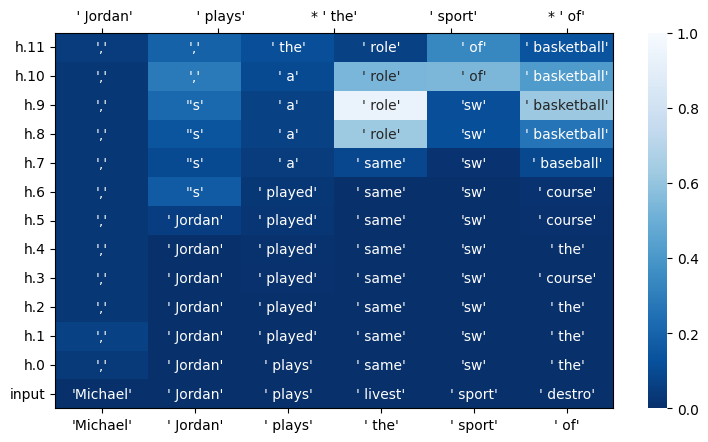

In [10]:
plot_logit_lens(model, tokenizer, input_ids1, start_ix=0, end_ix=input_ids1.numel(), probs=True)

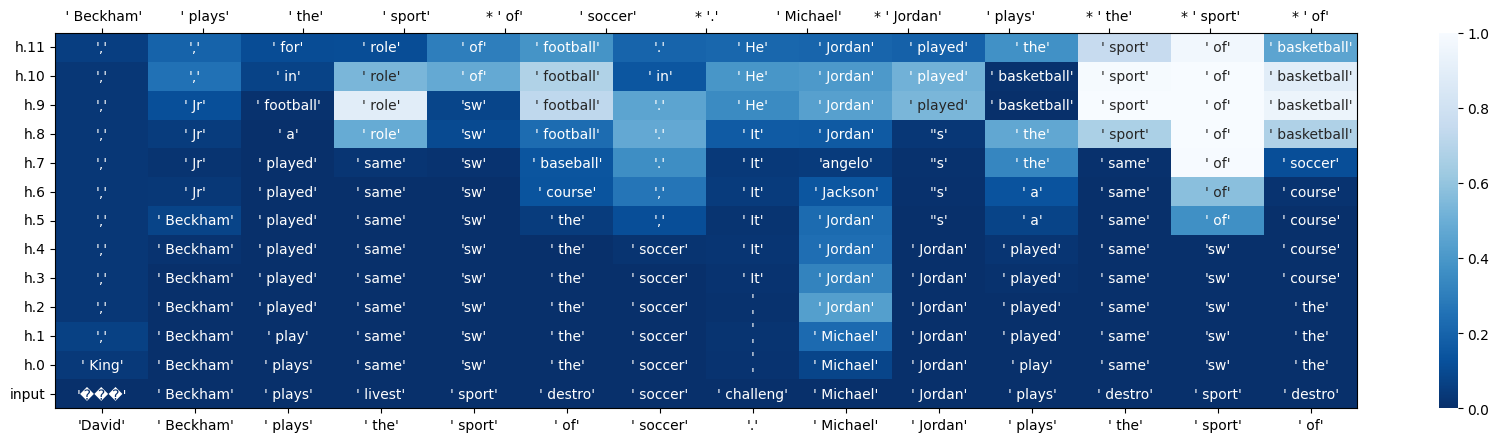

In [11]:
plot_logit_lens(model, tokenizer, input_ids2, start_ix=0, end_ix=input_ids2.numel(), probs=True)

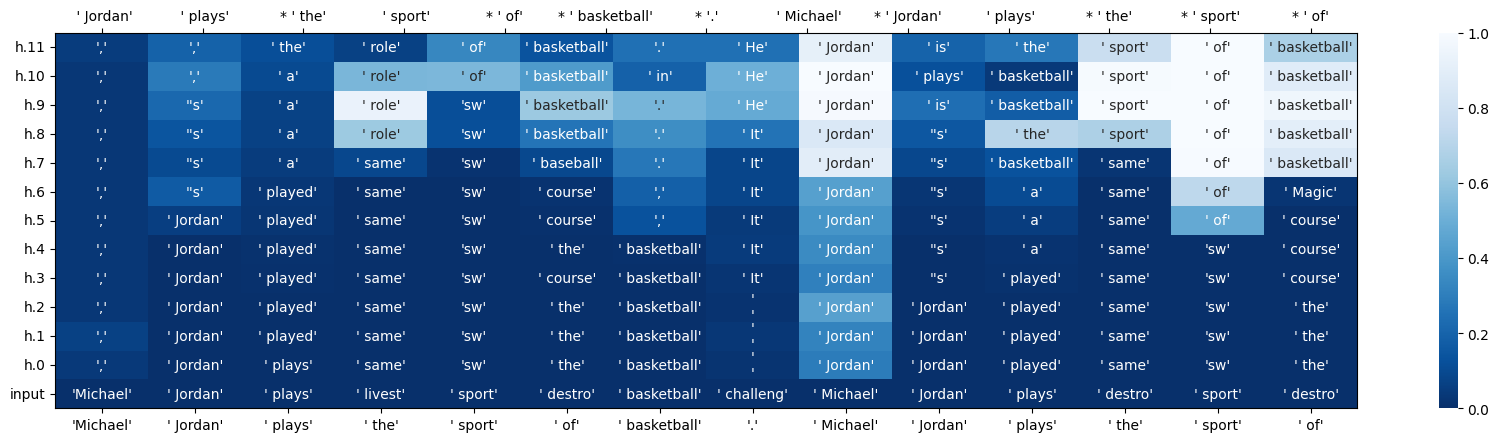

In [12]:
plot_logit_lens(model, tokenizer, input_ids3, start_ix=0, end_ix=input_ids3.numel(), probs=True)

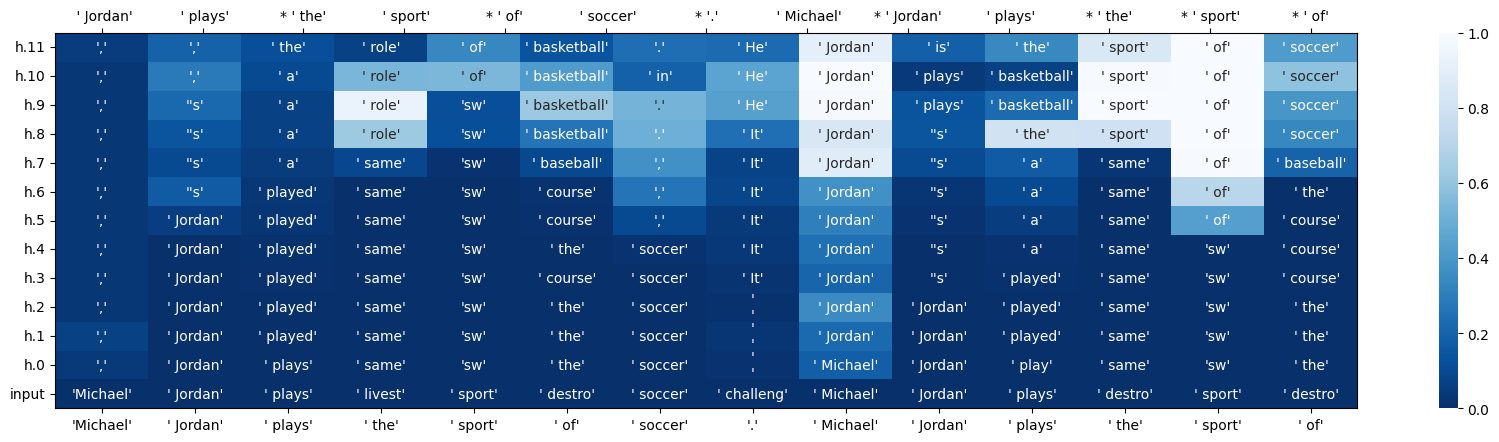

In [13]:
plot_logit_lens(model, tokenizer, input_ids4, start_ix=0, end_ix=input_ids4.numel(), probs=True)

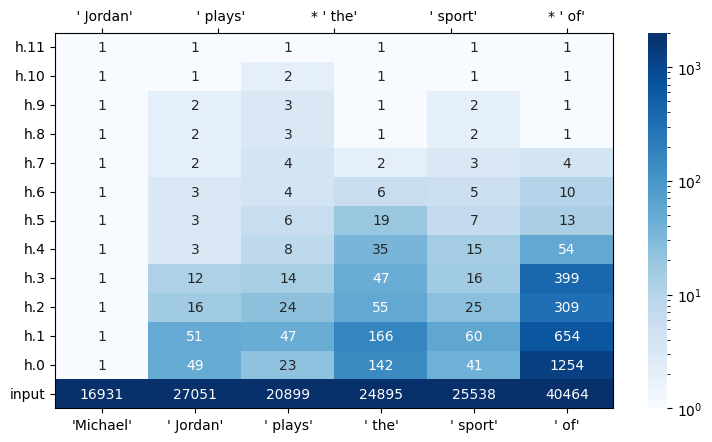

In [14]:
plot_logit_lens(model, tokenizer, input_ids1, start_ix=0, end_ix=input_ids1.numel(), ranks=True)

K-L divergence w/r/t the final output distribution.

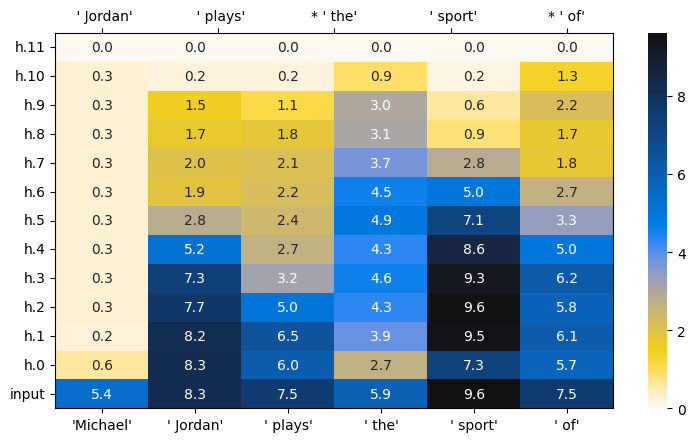

In [15]:
plot_logit_lens(model, tokenizer, input_ids1, start_ix=0, end_ix=input_ids1.numel(), kl=True)

##### subblocks

a transformer block is actually 2 residual layers: an attn part followed by an mlp part.

here, we break them down:

- predictions after just the attn part of a block
- predictions after the full block (= after the mlp part too)

let's do ranks for this one

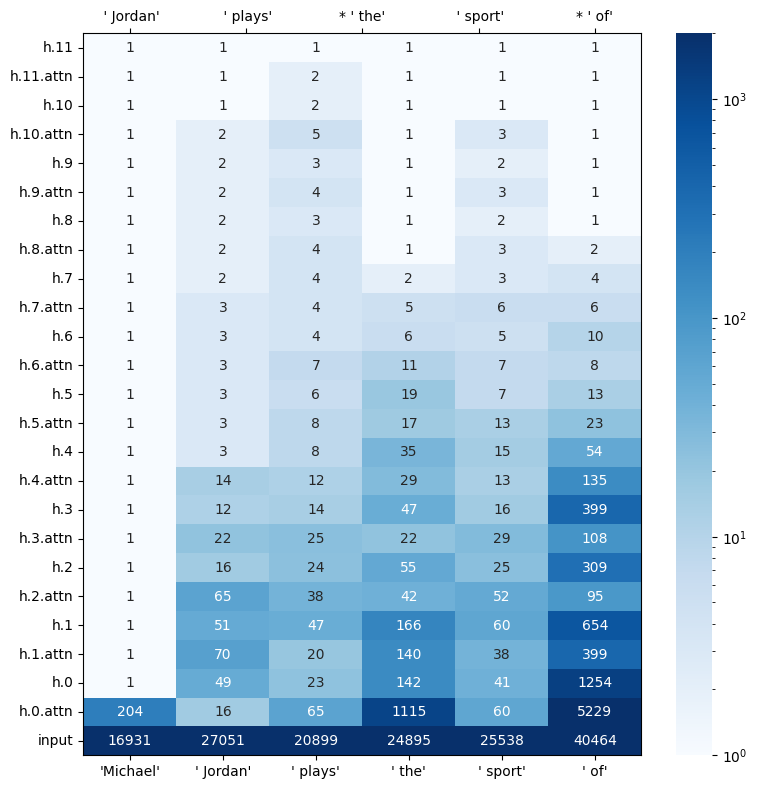

In [16]:
plot_logit_lens(model, tokenizer, input_ids1, start_ix=0, end_ix=input_ids1.numel(), ranks=True, include_subblocks=True)

##### extending the decoder

in the original post, i "decoded" each layer with the "decoder" applied to the final block of the model:

- start with a layer's output
- apply a layer norm
  - in the post i used a "bare" layer norm with no shift/scale
  - here we'll use the model's `ln_f` (which is what the model actually uses when decoding from the last layer)
- multiply by the transposed embedding matrix

this effectively chooses a part of the model at the top, says "this is the decoder," and feeds other stuff through it.

----

what if we extend that subset?  for ex., we could view the last layer itself as the first step of the "decoder":

- start with a layer's output
- run the final layer
- run `ln_f`
- multiply by the transposed embedding matrix

in the next cell, i do that (plotting ranks, with subblocks).

it's not super exciting for gpt-2, but it will be for gpt-neo

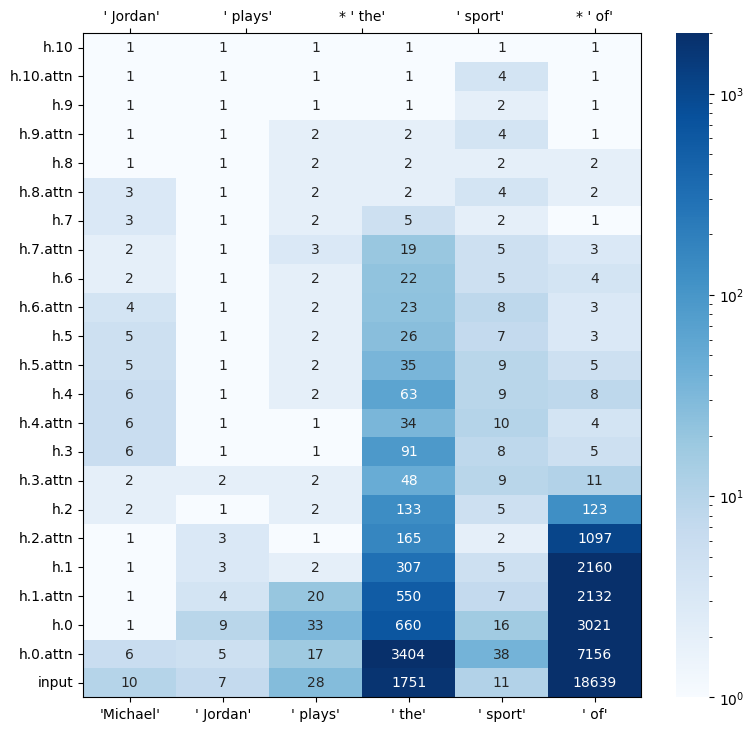

In [19]:
plot_logit_lens(model, tokenizer, input_ids1, start_ix=0, end_ix=input_ids1.numel(), ranks=True, include_subblocks=True,
                decoder_layer_names=['h.11', 'final_layernorm', 'lm_head'])